In [ ]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import sklearn.datasets
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
test_size = 0.2
random_state= 1000

# read data
uk_data_filename = "ar-2010-2014-xlsb.csv"
data = pd.read_csv(uk_data_filename, error_bad_lines=False, sep=';', low_memory=False)
data = data[data["Type of treatment - IVF or DI"]=="IVF"]
#columns_to_keep= ['Live Birth Occurrence','Embryos (from Eggs Micro-injected) Stored For Use By Patient','Embryos Stored For Use By Patient','Embryos Transfered from Eggs Micro-injected','Embryos Transfered','Total Embryos Thawed','Embryos from Eggs Micro-injected','Eggs Micro-injected','Total Embryos Created','Eggs Mixed With Donor sperm','Eggs Mixed With Partner Sperm','Total Eggs Mixed','Fresh Eggs Stored','Fresh Eggs Collected','Eggs Thawed','Frozen Cycle','Fresh Cycle','Sperm From','Egg Source','Elective Single Embryo Transfer','PGS Treatment','PGS','PGD treatment','PGD','Specific treatment type','Type of treatment - IVF or DI','Patient acting as Surrogate','Donated embryo','Sperm Donor Age at Registration','Egg Donor Age at Registration','Type of Ovulation Induction','Stimulation used','Main Reason for Producing Embroys Storing Eggs','Cause of Infertility -  Partner Sperm Immunological factors','Causes of Infertility - Partner Sperm Motility','Cause of Infertility -  Partner Sperm Morphology','Cause of Infertility - Partner Sperm Concentration','Cause of Infertility - Female Factors','Cause of Infertility - Cervical factors','Cause of Infertility - Endometriosis','Cause of Infertility - Patient Unexplained','Cause of Infertility - Male Factor','Cause of Infertility - Ovulatory Disorder','Cause  of Infertility - Tubal disease','Type of Infertility -Couple Secondary','Type of Infertility -Couple Primary','Type of Infertility - Male Secondary','Type of Infertility - Male Primary','Type of Infertility - Female Secondary','Type of Infertility - Female Primary','Total number of live births - conceived through DI','Total number of live births - conceived through IVF','Total number of live births - conceived through IVF or DI','Total number of DI pregnancies','Total number of IVF pregnancies','Total number of previous pregnancies, Both IVF and DI','Total Number of Previous DI cycles','Total Number of Previous IVF cycles','Total Number of Previous treatments, Both IVF and DI at clinic','Total Number of Previous cycles, Both IVF and DI','Date patient started trying to become pregnant OR date of last pregnancy','Patient Age at Treatment']
columns_to_keep= ['Live Birth Occurrence','Frozen Cycle','Fresh Cycle','Sperm From','Egg Source',
                            'Stimulation used','Cause of Infertility -  Partner Sperm Immunological factors','Causes of Infertility - Partner Sperm Motility','Cause of Infertility -  Partner Sperm Morphology','Cause of Infertility - Partner Sperm Concentration','Cause of Infertility - Cervical factors','Cause of Infertility - Endometriosis','Cause of Infertility - Patient Unexplained','Cause of Infertility - Male Factor','Cause of Infertility - Ovulatory Disorder','Cause  of Infertility - Tubal disease',
                            'Total number of live births - conceived through IVF or DI','Total number of previous pregnancies, Both IVF and DI','Total Number of Previous cycles, Both IVF and DI','Date patient started trying to become pregnant OR date of last pregnancy','Patient Age at Treatment']


def clean_data(data,columns_to_keep):   
    data_prep = data[columns_to_keep]
    data_prep = data_prep.fillna(0)
    data_prep.replace(["> 50",'>=5'],[60,6], inplace=True)
    for col in data_prep.select_dtypes(include=['object']).columns:
        data_prep[col].replace(["18 - 34",'35-37','38-39','40-42','43-44','45-50',999],[1,2,3,4,5,6,7], inplace=True)
        data_prep[col].replace(["<= 20","Between 21 and 25","Between 26 and 30","Between 31 and 35",999],[1,2,3,4,2.5],inplace=True)
        data_prep[col] = data_prep[col].astype(int,errors='ignore')
    
    # One-hot encode the data using pandas get_dummies
    data_prep = data_prep[data_prep['Patient Age at Treatment']!=999]
    data_prep = pd.get_dummies(data_prep)
   
    return data_prep

data_prep = clean_data(data,columns_to_keep)

def prepare_train_and_test(data_prep,random_state,test_size):
    # Labels are the values we want to predict
    labels = np.array(data_prep[u'Live Birth Occurrence'])

    # Remove the labels from the features
    features= data_prep.drop(u'Live Birth Occurrence', axis = 1)
    # Saving feature names for later use
    feature_list = list(features.columns)
    features = np.array(features)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_size, random_state = random_state)

    return train_features, test_features, train_labels, test_labels, feature_list

train_features, test_features, train_labels, test_labels, feature_list = prepare_train_and_test(data_prep,random_state,test_size)

data_prep.head()

In [13]:
# feature extraction
pca = PCA(n_components=2)
fit = pca.fit(train_features)

principalComponents = pca.fit_transform(train_features)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df_train_labels = pd.DataFrame(train_labels,columns = ['target'])
finalDf = pd.concat([principalDf, df_train_labels], axis = 1)
finalDf

,principal component 1,principal component 2,target
0,-0.866094,0.518763,0.0
1,-0.866447,0.531034,0.0
2,-0.553929,0.385934,1.0
3,0.311550,-1.333263,0.0
4,-1.228989,1.277010,1.0
5,-1.217696,1.289707,0.0
6,-1.125729,1.112459,1.0
7,0.132875,-0.945419,1.0
8,2.344188,-3.808021,0.0
9,-0.525785,-0.264877,0.0


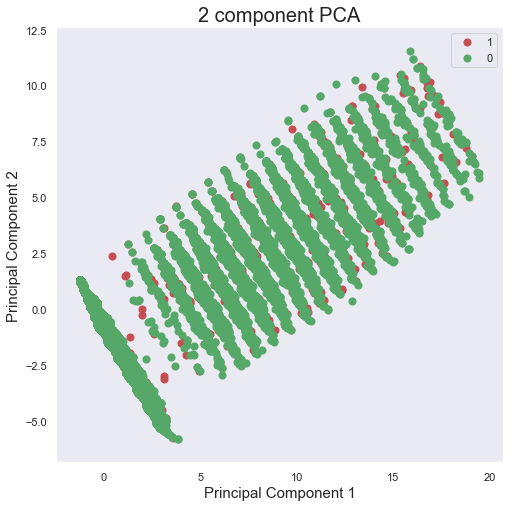

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [ ]:

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

perf = []
classifiers = [
    KNeighborsClassifier(3), #later
    #SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),  # 1 -> finetuner les hyper param
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    #DecisionTreeClassifier(max_depth=5), 
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features='sqrt'), # 2
    #MLPClassifier(alpha=1),
    AdaBoostClassifier(), #GradiantBoosting, a chercher Extreme G Boost # 3
    GaussianNB(),
    #QuadraticDiscriminantAnalysis()
    # a tester  RegressionLogisitic (avec kernel optimisé)
]

#voting_classifier = VotingClassifier(
#        estimators = [ ('knc', KNeighborsClassifier(3)), ('')]
#        voting= 'hard'
#    )
for clf in classifiers:
    clf.fit(train_features,train_labels)
    pred_labels = clf.predict(test_features)
    #accuracy_score = accuracy_score(test_labels,pred_labels)
    #perf.append({'clf': clf.__class__.__name__, 'accuracy_score': accuracy_score(test_labels,pred_labels) })
    #perf = pd.DataFrame(perf)
    #print(clf.__class__.__name__,accuracy_score(test_labels,pred_labels))
    matrix = confusion_matrix(test_labels, pred_labels)
    print(matrix)
    
perf

[[40539  6217]
 [12983  2621]]
[[46756     0]
 [15604     0]]
[[46381   375]
 [15431   173]]


In [4]:
## use GridSearchCV
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}


def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(train_features, train_labels)

    # make the predictions
    y_pred = grid_search.predict(test_features)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(test_labels, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='precision_score')

results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

KeyboardInterrupt: 

/Users/samyabarkaoui/Documents/1_AI/env/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/backend/semlock.py:217: RuntimeWarning: semaphore are broken on OSX, release might increase its maximal value
  "increase its maximal value", RuntimeWarning)
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/Users/samyabarkaoui/Documents/1_AI/env/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/backend/queues.py", line 175, in _feed
    onerror(e, obj)
  File "/Users/samyabarkaoui/Documents/1_AI/env/lib/python2.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py", line 310, in _on_queue_feeder_error
    self.th